# **ESENSE - EARABLE IMU DATA COLLECTOR**

This notebook will connect to your esense earable having IMU and will create a csv file with name 'imu_data.csv' in the same directory. it will replace everytime you run the data collection code.

You can tweek every parameter the Esense IMU earable have. Follow the instructions.


-- Sameeran Zingre :)


In [58]:
# LETS GET STARTED.....

# First you have to replace this MAC address with your Esense device's MAC ADDRESS. 
# (You can find it in the Device properties under ' bluetooth ' tab as ' Unique Id ')
ESENSE_MAC_ADDRESS = "00:04:79:00:0e:16"

# Now run the connection code below. Once the connection is Succesfull. you can tweek and configure the IMU parameters below.

**ESENSE CONNECTION**

if connection is unable to establish. 
 - Check MAC address 
 - try reconnect the eSense to your computer.
 - Ensure No other device is connected.

In [82]:
import asyncio
from bleak import BleakClient

import nest_asyncio
nest_asyncio.apply()
import pandas as pd
import matplotlib.pyplot as plt
# Replace with your device's MAC address

client = None

async def connect_earable():
    """Function to establish connection to eSense earable."""
    global client
    client = BleakClient(ESENSE_MAC_ADDRESS)
    await client.connect()

    if client.is_connected:
        print("Connected to eSense earable")
    else:
        print("Failed to connect to the device")

# Run the connection asynchronously
loop = asyncio.get_event_loop()
loop.run_until_complete(connect_earable())

Connected to eSense earable


Once the connection is established, move to configuration panel. Tweek the parameters as you like.

*Gyroscope calibration values are 0*

RUN THIS BELOW FUNCTION TO CHECK THE CALIBRATION OFFSETS.

In [83]:
########################### CURRENT CALIBRATION CHECKER ###############################


# UUID for the accelerometer factory offset characteristic
UUID_ACCEL_CALIBRATION = "0000ff0d-0000-1000-8000-00805f9b34fb"

# Global variable to store calibration offsets
accel_offset_x = 0
accel_offset_y = 0
accel_offset_z = 0

# Function to convert two bytes to a signed 16-bit integer
import struct

def bytes_to_int16(byte1, byte2):
    """Convert two bytes to a signed 16-bit integer."""
    return struct.unpack('<h', bytearray([byte1, byte2]))[0]

async def get_calibration_offsets():
    """Function to retrieve accelerometer calibration offsets."""
    global accel_offset_x, accel_offset_y, accel_offset_z
    if client and client.is_connected:
        calibration_data = await client.read_gatt_char(UUID_ACCEL_CALIBRATION)
    
        # Parse the calibration data (6 bytes for 3 int16 offsets)
        accel_offset_x = bytes_to_int16(calibration_data[9], calibration_data[10])
        accel_offset_y = bytes_to_int16(calibration_data[11], calibration_data[12])
        accel_offset_z = bytes_to_int16(calibration_data[13], calibration_data[14])
        
        print(f"Calibration Offsets - X: {accel_offset_x}, Y: {accel_offset_y}, Z: {accel_offset_z}")
    else:
        print("Device is not connected")

# Run the calibration offset retrieval asynchronously
loop.run_until_complete(get_calibration_offsets())


Calibration Offsets - X: 5859, Y: -30193, Z: 30240


YOU CAN CHANGE THE RANGE OF THE GYRO AND ACCEL MEASUREMENT.

In [84]:
# Select Gyroscope range (This is the maximum range of the Gyroscope it will measure):
# 1. ±250 deg/s
# 2. ±500 deg/s
# 3. ±1000 deg/s
# 4. ±2000 deg/s

gyro_config_choice = 2 # default will be +- 500 deg/s


# Select Accelerometer range (This is the maximum range of the Accelerometer it will measure):
# 1. ±2g
# 2. ±4g
# 3. ±8g
# 4. ±16g

accel_config_choice = 2 # default choice is +- 4g

# NOTE : THE SCALE FACTORS ARE CALCULATED AUTOMATICALY BASED ON THE SELECTED CONFIGURATION CHOICE


In [85]:
################################# CONFIGURER #####################################

UUID_IMU_CONFIG = "0000ff0e-0000-1000-8000-00805f9b34fb"

# Gyroscope and Accelerometer scale factors for different ranges
GYRO_SCALE_FACTORS = {
    "250": 131,   # LSB/(deg/s)
    "500": 65.5,
    "1000": 32.8,
    "2000": 16.4
}

ACCEL_SCALE_FACTORS = {
    "2g": 16384,  # LSB/g
    "4g": 8192,
    "8g": 4096,
    "16g": 2048
}

global gyro_scale_factor , accel_scale_factor
async def read_imu_configuration():

    if client and client.is_connected:
        
            global gyro_scale_factor , accel_scale_factor
            # Read current IMU configuration
            imu_config = await client.read_gatt_char(UUID_IMU_CONFIG)
            _,_,_, data0, data1, data2, data3 = imu_config


            if gyro_config_choice == 1:
                data1 = (data1 & 0b11100011) | (0b00 << 3)
                gyro_scale_factor = GYRO_SCALE_FACTORS["250"]
            elif gyro_config_choice == 2:
                data1 = (data1 & 0b11100011) | (0b01 << 3)
                gyro_scale_factor = GYRO_SCALE_FACTORS["500"]
            elif gyro_config_choice == 3:
                data1 = (data1 & 0b11100011) | (0b10 << 3)
                gyro_scale_factor = GYRO_SCALE_FACTORS["1000"]
            elif gyro_config_choice == 4:
                data1 = (data1 & 0b11100011) | (0b11 << 3)
                gyro_scale_factor = GYRO_SCALE_FACTORS["2000"]
            else:
                print("Invalid choice! Defaulting to ±500 deg/s.")
                data1 = (data1 & 0b11100011) | (0b01 << 3)
                gyro_scale_factor = GYRO_SCALE_FACTORS["500"]


            if accel_config_choice == 1:
                data2 = (data2 & 0b11100011) | (0b00 << 3)
                accel_scale_factor = ACCEL_SCALE_FACTORS["2g"]
            elif accel_config_choice == 2:
                data2 = (data2 & 0b11100011) | (0b01 << 3)
                accel_scale_factor = ACCEL_SCALE_FACTORS["4g"]
            elif accel_config_choice == 3:
                data2 = (data2 & 0b11100011) | (0b10 << 3)
                accel_scale_factor = ACCEL_SCALE_FACTORS["8g"]
            elif accel_config_choice == 4:
                data2 = (data2 & 0b11100011) | (0b11 << 3)
                accel_scale_factor = ACCEL_SCALE_FACTORS["16g"]
            else:
                print("Invalid choice! Defaulting to ±4g.")
                data2 = (data2 & 0b11100011) | (0b01 << 3)
                accel_scale_factor = ACCEL_SCALE_FACTORS["4g"]

            # Calculate checksum (DataSize + Data0 + Data1 + Data2 + Data3)
            data_size = 0x04
            checksum = (data_size + data0 + data1 + data2 + data3) & 0xFF

            # Write the updated configuration back to the IMU
            new_config = bytearray([0x59, checksum, data_size, data0, data1, data2, data3])
            await client.write_gatt_char(UUID_IMU_CONFIG, new_config)
            print("Updated IMU configuration written successfully")

            # Print the selected configuration and scale factors
            print(f"Selected Gyro Range: ±{list(GYRO_SCALE_FACTORS.keys())[int(gyro_config_choice)-1]} deg/s")
            print(f"Selected Accelerometer Range: ±{list(ACCEL_SCALE_FACTORS.keys())[int(accel_config_choice)-1]}")
            print(f"Gyroscope Scale Factor: {gyro_scale_factor} LSB/(deg/s)")
            print(f"Accelerometer Scale Factor: {accel_scale_factor} LSB/g")

loop.run_until_complete(read_imu_configuration())

Updated IMU configuration written successfully
Selected Gyro Range: ±500 deg/s
Selected Accelerometer Range: ±4g
Gyroscope Scale Factor: 65.5 LSB/(deg/s)
Accelerometer Scale Factor: 8192 LSB/g


**LOW PASS FILTER SETTINGS**


There is No High pass filter in the eSense. However you can set the Low pass filter Cut off frequency for both gyroscope and Accelerometer.

In [107]:
  
# GYROSCOPE LPF CHOICE
  # 0: 250,
    # 1: 184,
    # 2: 92,
    # 3: 41,
    # 4: 20,
    # 5: 10,
    # 6: 5,
    # 7: 3600


# ACCELEROMETER LPF CHOICE
    # 0: 460,
    # 1: 184,
    # 2: 92,
    # 3: 41,
    # 4: 20,
    # 5: 10,
    # 6: 5

gyro_cut_off = 6
accel_cut_off = 6

# once you set the values run the below cell

In [108]:
############################ LPF CONFIGURATIONS ##########################
GYRO_LPF_OPTIONS = {
    0: 250,
    1: 184,
    2: 92,
    3: 41,
    4: 20,
    5: 10,
    6: 5,
    7: 3600
}

ACCEL_LPF_OPTIONS = {
    0: 460,
    1: 184,
    2: 92,
    3: 41,
    4: 20,
    5: 10,
    6: 5
}

async def read_imu_lpf_configuration(client):
    """Read the current LPF configuration for gyroscope and accelerometer."""
    if client and client.is_connected:
        # Read current IMU configuration
        imu_config = await client.read_gatt_char(UUID_IMU_CONFIG)
        _, _, _, data0, data1, data2 , data3 = imu_config

        # Extract the Gyroscope LPF configuration
        gyro_lpf_bypass = data1 & 0b00000011
        gyro_lpf_conf = data0 & 0b00000111
        
        if gyro_lpf_bypass:
            print("Gyroscope LPF is bypassed.")
        else:
            print(f"Current Gyroscope LPF is  {GYRO_LPF_OPTIONS[gyro_lpf_conf]} Hz bandwidth.")

        # Extract the Accelerometer LPF configuration
        accel_lpf_bypass = (data3 >> 3) & 0b00000001
        accel_lpf_conf = data3 & 0b00000111
        
        if accel_lpf_bypass:
            print("Accelerometer LPF is bypassed.")
        else:
            print(f"Current Accelerometer LPF is  {ACCEL_LPF_OPTIONS[accel_lpf_conf]} Hz bandwidth.")
    else:
        print("Device is not connected.")

async def update_imu_lpf_configuration(client, gyro_lpf_choice=None, accel_lpf_choice=None):
    """Update the LPF configuration for gyroscope and accelerometer."""
    if client and client.is_connected:
        # Read current IMU configuration
        imu_config = await client.read_gatt_char(UUID_IMU_CONFIG)
        _, _, _, data0, data1, data2 , data3 = imu_config
        # Update Gyroscope LPF configuration if a new choice is provided
        if gyro_lpf_choice is not None:
            if gyro_lpf_choice in GYRO_LPF_OPTIONS:
                # Set LPF bypass to 0 (use LPF) and update configuration bits
                data1 = data1 & 0b11111100  # Clear bits [1:0] for gyro LPF bypass
                data0 = (data0 & 0b11111000) | (gyro_lpf_choice & 0b00000111)
                print(f"Setting Gyroscope LPF to {GYRO_LPF_OPTIONS[gyro_lpf_choice]} Hz.")
            else:
                print("Invalid Gyroscope LPF choice.")

        # Update Accelerometer LPF configuration if a new choice is provided
        if accel_lpf_choice is not None:
            if accel_lpf_choice in ACCEL_LPF_OPTIONS:
                # Set LPF bypass to 0 (use LPF) and update configuration bits
                data3 = (data3 & 0b11110111)  # Clear bit 3 for accel LPF bypass
                data3 = (data3 & 0b11111000) | (accel_lpf_choice & 0b00000111)
                print(f"Setting Accelerometer LPF to {ACCEL_LPF_OPTIONS[accel_lpf_choice]} Hz.")
            else:
                print("Invalid Accelerometer LPF choice.")

        # Calculate checksum (DataSize + Data0 + Data1 + Data2 + Data3)
        data_size = 0x04
        checksum = (data_size +  data0 + data1 + data2 + data3) & 0xFF

        # Write the updated configuration back to the IMU
        new_config = bytearray([0x59, checksum, data_size, data0, data1, data2, data3])
        await client.write_gatt_char(UUID_IMU_CONFIG, new_config)

        print("Updated IMU LPF configuration written successfully.")
    else:
        print("Device is not connected.")

# Example usage:
asyncio.run(read_imu_lpf_configuration(client))
asyncio.run(update_imu_lpf_configuration(client, gyro_lpf_choice=gyro_cut_off, accel_lpf_choice=accel_cut_off))


Current Gyroscope LPF is  92 Hz bandwidth.
Current Accelerometer LPF is  92 Hz bandwidth.
Setting Gyroscope LPF to 5 Hz.
Setting Accelerometer LPF to 5 Hz.
Updated IMU LPF configuration written successfully.


START SAMPLING FOR ESENSE

Note: starting sampling doest not mean your data will get calculated. It will just start mearsuring the IMU values.
You can stop the sampling after you are done with the measurement without disconnecting.


SAMPLING CAN BE DONE IN 50Hz or in 20Hz.

In [109]:
# Command to start IMU sampling at 50Hz
START_IMU_COMMAND = bytearray([0x53, 0x35, 0x02, 0x01, 0x32]) # uncomment for 50Hz sampling
# START_IMU_COMMAND = bytearray([0x53, 0x17, 0x02, 0x01, 0x14]) #uncomment for 20Hz sampling

In [110]:
####################################### SAMPLING INITIATION ##################
UUID_IMU_CONTROL = "0000ff07-0000-1000-8000-00805f9b34fb"


async def start_sampling():
    
    if client and client.is_connected:
        await client.write_gatt_char(UUID_IMU_CONTROL, START_IMU_COMMAND)
        print("IMU sampling started")
    else:
        print("Device is not connected")

# Run the sampling start command asynchronously

loop.run_until_complete(start_sampling())


IMU sampling started



- GYRO VALUES ARE IN deg/sec


- ACCEL values are in m/s^2 


In [111]:
# SET TIME FOR WHICH YOU WANT TO HAVE THE MEASUREMENTS.
timer = 10  # in seconds

In [118]:
################################################# DATA collection ####################################

import csv
import os

UUID_IMU_DATA = "0000ff08-0000-1000-8000-00805f9b34fb"

# Path to save the CSV file
output_file = "imu_data.csv"


# Ensure the file does not already exist
if os.path.exists(output_file):
    os.remove(output_file)


with open(output_file, mode='w', newline='') as file:
    writer = csv.writer(file)
 
    writer.writerow(['Timestamp', 'Accel_X_g', 'Accel_Y_g', 'Accel_Z_g', 'Gyro_X_deg_per_s', 'Gyro_Y_deg_per_s', 'Gyro_Z_deg_per_s'])

def parse_and_convert_imu_data_with_calibration(data):
    if data[0] != 0x55:
        raise ValueError("Invalid CmdHead, expected 0x55")

    sensor_data = data[4:16]

    # Gyroscope data (no offsets for gyro)
    gyro_x = bytes_to_int16(sensor_data[0], sensor_data[1])
    gyro_y = bytes_to_int16(sensor_data[2], sensor_data[3])
    gyro_z = bytes_to_int16(sensor_data[4], sensor_data[5])

    # Accelerometer data (apply offsets)
    accel_x = bytes_to_int16(sensor_data[6], sensor_data[7]) - accel_offset_x
    accel_y = bytes_to_int16(sensor_data[8], sensor_data[9]) - accel_offset_y
    accel_z = bytes_to_int16(sensor_data[10], sensor_data[11]) - accel_offset_z

    # accel_x = bytes_to_int16(sensor_data[6], sensor_data[7]) 
    # accel_y = bytes_to_int16(sensor_data[8], sensor_data[9]) 
    # accel_z = bytes_to_int16(sensor_data[10], sensor_data[11]) 


    accel_x_g = (accel_x / accel_scale_factor) * 9.80665  
    accel_y_g = (accel_y / accel_scale_factor) * 9.80665
    accel_z_g = (accel_z / accel_scale_factor) * 9.80665

    gyro_x_deg_per_s = gyro_x  / gyro_scale_factor 
    gyro_y_deg_per_s = gyro_y / gyro_scale_factor
    gyro_z_deg_per_s = gyro_z / gyro_scale_factor

    formatted_data = [accel_x_g, accel_y_g, accel_z_g, gyro_x_deg_per_s, gyro_y_deg_per_s, gyro_z_deg_per_s]
    return formatted_data

timestamps = 0
async def imu_data_callback_with_calibration(sender, data):
    global timestamps
    """Callback function to handle incoming IMU data."""
    try:
        parsed_data = parse_and_convert_imu_data_with_calibration(data)
        #print(f"Received IMU data: {parsed_data}")
    except ValueError as e:
        print(f"Error parsing IMU data: {e}")
        return
    
    # Save the data to a CSV file
    with open(output_file, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([timestamps] + parsed_data)
        timestamps += 1

# Function to start collecting IMU data with calibration applied
async def collect_data_with_calibration():
   
    if client and client.is_connected:
        await client.start_notify(UUID_IMU_DATA, imu_data_callback_with_calibration)
        print("Subscribed to IMU data notifications with calibration")

        await asyncio.sleep(timer)

        await client.stop_notify(UUID_IMU_DATA)
        print("Stopped collecting IMU data")
    else:
        print("Device is not connected")

# Run the data collection command asynchronously
loop.run_until_complete(collect_data_with_calibration())



Subscribed to IMU data notifications with calibration
Stopped collecting IMU data


FUNCTION TO STOP IMU SAMPLING

In [78]:
# Command to stop IMU sampling
STOP_IMU_COMMAND = bytearray([0x53, 0x02, 0x02, 0x00, 0x00])

async def stop_sampling():
    """Function to stop IMU sampling."""
    if client and client.is_connected:
        await client.write_gatt_char(UUID_IMU_CONTROL, STOP_IMU_COMMAND)
        print("IMU sampling stopped")
    else:
        print("Device is not connected")

# Run the stop sampling command asynchronously
loop.run_until_complete(stop_sampling())


IMU sampling stopped


DISCONNECTION

In [79]:
async def disconnect_earable():
    """Function to disconnect from eSense earable."""
    if client and client.is_connected:
        await client.disconnect()
        print("Disconnected from eSense earable")
    else:
        print("Device is not connected")

# Run the disconnect command asynchronously
loop.run_until_complete(disconnect_earable())


Disconnected from eSense earable


VISUALIZATION

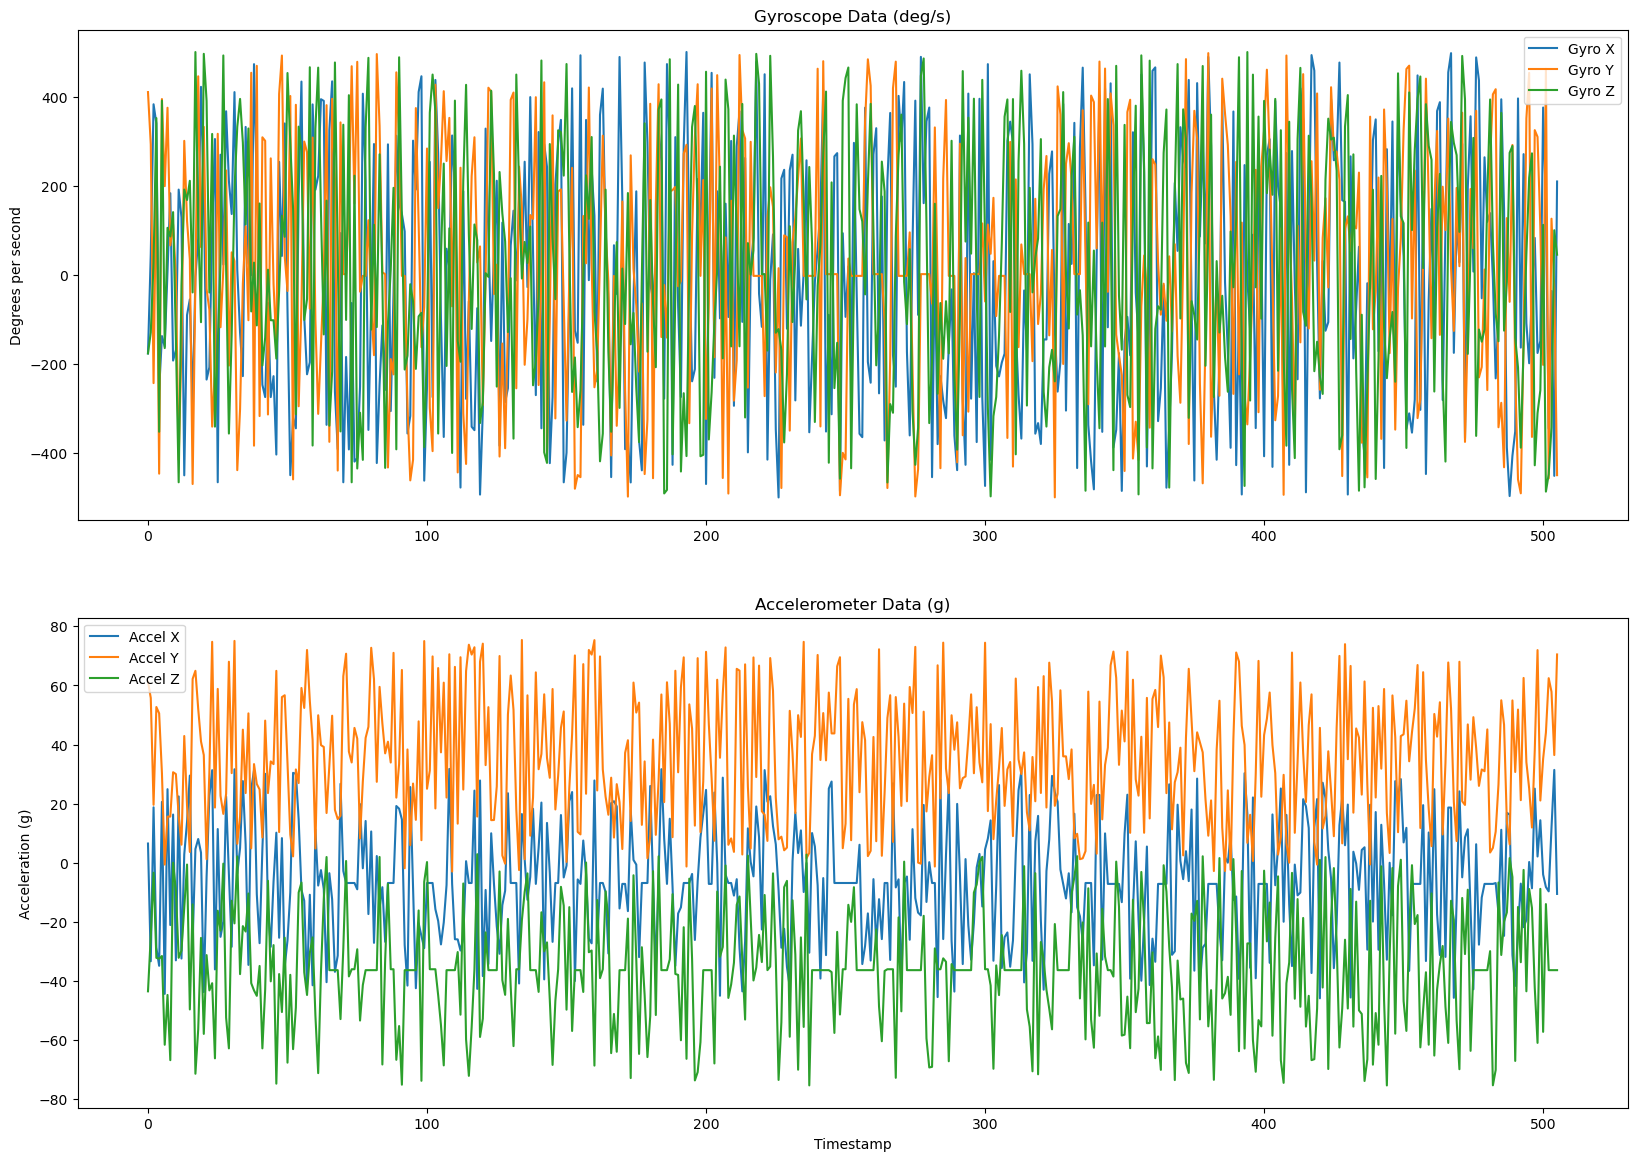

In [119]:
# Load the CSV file
df = pd.read_csv('imu_data.csv')

# Plot gyroscope data
plt.figure(figsize=(20, 14))
plt.subplot(2, 1, 1)
plt.plot(df['Timestamp'], df['Gyro_X_deg_per_s'], label='Gyro X')
plt.plot(df['Timestamp'], df['Gyro_Y_deg_per_s'], label='Gyro Y')
plt.plot(df['Timestamp'], df['Gyro_Z_deg_per_s'], label='Gyro Z')
plt.title('Gyroscope Data (deg/s)')
plt.ylabel('Degrees per second')
plt.legend()

# Plot accelerometer data
plt.subplot(2, 1, 2)
plt.plot(df['Timestamp'], df['Accel_X_g'], label='Accel X')
plt.plot(df['Timestamp'], df['Accel_Y_g'], label='Accel Y')
plt.plot(df['Timestamp'], df['Accel_Z_g'], label='Accel Z')
plt.title('Accelerometer Data (g)')
plt.ylabel('Acceleration (g)')
plt.xlabel('Timestamp')
plt.legend()

plt.show()